In [10]:
import librosa
import glob
import librosa.display
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
wavfile='/content/drive/MyDrive/MiniProject/Dataset/Bengali/ben_0001.wav'

In [4]:
wavfile

'/content/drive/MyDrive/MiniProject/Dataset/Bengali/ben_0001.wav'

In [5]:
signal,sample_rate=librosa.load(wavfile)

In [6]:
signal

array([0.00464754, 0.00404419, 0.0035789 , ..., 0.00117585, 0.00078438,
       0.        ], dtype=float32)

In [7]:
sample_rate

22050

In [33]:
import pandas as pd
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [13]:
path="/content/drive/MyDrive/MiniProject/Dataset"

In [14]:
audio_list=[]
label_list=[]
full_path_list=[]
for j in os.listdir(path):
  for i in os.listdir(path+'/'+j):
    audio_list.append(i)
    label_list.append(j)
    full_path=path+"/"+j+"/"+i
    full_path_list.append(full_path)


In [17]:
metadata=pd.DataFrame(full_path_list,columns=['full path'])
metadata

,full path
0,/content/drive/MyDrive/MiniProject/Dataset/Ben...
1,/content/drive/MyDrive/MiniProject/Dataset/Ben...
2,/content/drive/MyDrive/MiniProject/Dataset/Ben...
3,/content/drive/MyDrive/MiniProject/Dataset/Ben...
4,/content/drive/MyDrive/MiniProject/Dataset/Ben...
...,...
345,/content/drive/MyDrive/MiniProject/Dataset/Mar...
346,/content/drive/MyDrive/MiniProject/Dataset/Mar...
347,/content/drive/MyDrive/MiniProject/Dataset/Mar...
348,/content/drive/MyDrive/MiniProject/Dataset/Mar...


In [22]:
metadata1=pd.DataFrame(audio_list,columns=['filename'])
metadata1

,filename
0,ben_0031.wav
1,ben_0005.wav
2,ben_0013.wav
3,ben_0021.wav
4,ben_0036.wav
...,...
345,mar_0029.wav
346,mar_0044.wav
347,mar_0025.wav
348,mar_0019.wav


In [19]:
metadata2=pd.DataFrame(label_list,columns=['Class'])
metadata2

,Class
0,Bengali
1,Bengali
2,Bengali
3,Bengali
4,Bengali
...,...
345,Marathi
346,Marathi
347,Marathi
348,Marathi


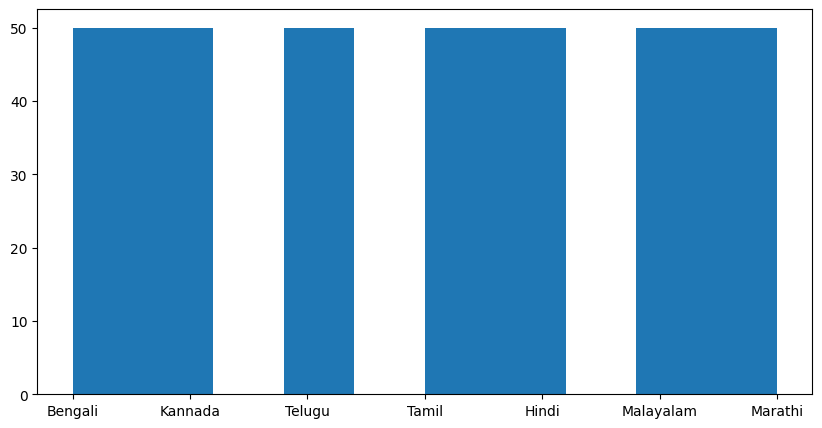

In [20]:
for column in metadata2.columns:
  plt.figure(figsize=(10,5))
  plt.hist(metadata2[column])
  plt.show()

In [23]:
final_metadata = pd.concat([metadata,metadata1, metadata2], axis=1)
final_metadata

,full path,filename,Class
0,/content/drive/MyDrive/MiniProject/Dataset/Ben...,ben_0031.wav,Bengali
1,/content/drive/MyDrive/MiniProject/Dataset/Ben...,ben_0005.wav,Bengali
2,/content/drive/MyDrive/MiniProject/Dataset/Ben...,ben_0013.wav,Bengali
3,/content/drive/MyDrive/MiniProject/Dataset/Ben...,ben_0021.wav,Bengali
4,/content/drive/MyDrive/MiniProject/Dataset/Ben...,ben_0036.wav,Bengali
...,...,...,...
345,/content/drive/MyDrive/MiniProject/Dataset/Mar...,mar_0029.wav,Marathi
346,/content/drive/MyDrive/MiniProject/Dataset/Mar...,mar_0044.wav,Marathi
347,/content/drive/MyDrive/MiniProject/Dataset/Mar...,mar_0025.wav,Marathi
348,/content/drive/MyDrive/MiniProject/Dataset/Mar...,mar_0019.wav,Marathi


In [25]:
def generate_fb_and_mfcc(signal, sample_rate):

    # Pre-Emphasis
    pre_emphasis = 0.97
    emphasized_signal = np.append(
        signal[0],
        signal[1:] - pre_emphasis * signal[:-1])

    # Framing
    frame_size = 0.025
    frame_stride = 0.01

    # Convert from seconds to samples
    frame_length, frame_step = (
        frame_size * sample_rate,
        frame_stride * sample_rate)
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))

    # Make sure that we have at least 1 frame
    num_frames = int(
        np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))

    # Pad Signal to make sure that all frames have equal
    # number of samples without truncating any samples
    # from the original signal
    pad_signal = np.append(emphasized_signal, z)

    indices = (
        np.tile(np.arange(0, frame_length), (num_frames, 1)) +
        np.tile(
            np.arange(0, num_frames * frame_step, frame_step),
            (frame_length, 1)
        ).T
    )
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    # Window
    frames *= np.hamming(frame_length)

    # Fourier-Transform and Power Spectrum
    NFFT = 512

    # Magnitude of the FFT
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))

    # Power Spectrum
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    # Filter Banks
    nfilt = 40

    low_freq_mel = 0

    # Convert Hz to Mel
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))

    # Equally spaced in Mel scale
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)

    # Convert Mel to Hz
    hz_points = (700 * (10**(mel_points / 2595) - 1))
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)

    # Numerical Stability
    filter_banks = np.where(
        filter_banks == 0,
        np.finfo(float).eps,
        filter_banks)

    # dB
    filter_banks = 20 * np.log10(filter_banks)
    return filter_banks

In [ ]:
path=list(final_metadata['full path'])
path

In [ ]:
features = generate_fb_and_mfcc(signal,sample_rate)
features

In [41]:
df=final_metadata

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(df,df['Class'],stratify = df['Class'],test_size = 0.3,random_state = 0)
print(X_train['Class'].value_counts())
print(X_test['Class'].value_counts())

In [45]:
# features_reshaped = features.reshape(350,350)
# Train a Random Forest classifier on the training set
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the classifier on the testing set
accuracy = clf.score(X_test, y_test)
print('Accuracy:', accuracy)

ValueError: ignored

In [46]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [47]:
knn = KNeighborsClassifier(n_neighbors=12)
# knn = KNeighborsClassifier(n_neighbors=5)

In [48]:
knn.fit(X_train, y_train)

ValueError: ignored